In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/creditcardfraud/creditcard.csv


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import IsolationForest

import warnings
warnings.filterwarnings('ignore')

In [3]:
df=pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')
pd.set_option('display.max_columns', None)
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
df['Amount'].dtype

dtype('float64')

In [5]:
df_known = df[['Time','Amount','Class']]
df_known.describe()

,Time,Amount,Class
count,284807.000000,284807.000000,284807.000000
mean,94813.859575,88.349619,0.001727
std,47488.145955,250.120109,0.041527
min,0.000000,0.000000,0.000000
25%,54201.500000,5.600000,0.000000
50%,84692.000000,22.000000,0.000000
75%,139320.500000,77.165000,0.000000
max,172792.000000,25691.160000,1.000000


## Aim for the Project :
***
* Make 2 Datasets one with Class and other without
    * Make 2 separate models for them for anomaly detction
* Make a classification Model with Class feature
* Comapre trhe results of all these 3 models
***

### Steps:-
***
* Not much to do in EDA, still can find corelation with Class
* For Anomaly Detection:-
    * Further do a PCA with all the features
    * Apply DSCAN, Isolation Forest, LOF and One SVM  
***
* For Classification:-
    * Oversampling and remove data class imbalance
    * Apply Robost Scaler(to tackel outliers)
    * Make SVM, Decision and Random Forest and Gradient Boosting and XGBoost
***

Pre Processing:-
***
    * Roboust Scaler
    * Outlier Removal(check if outliers are of class 1 or not)

#### Outliers Treatment

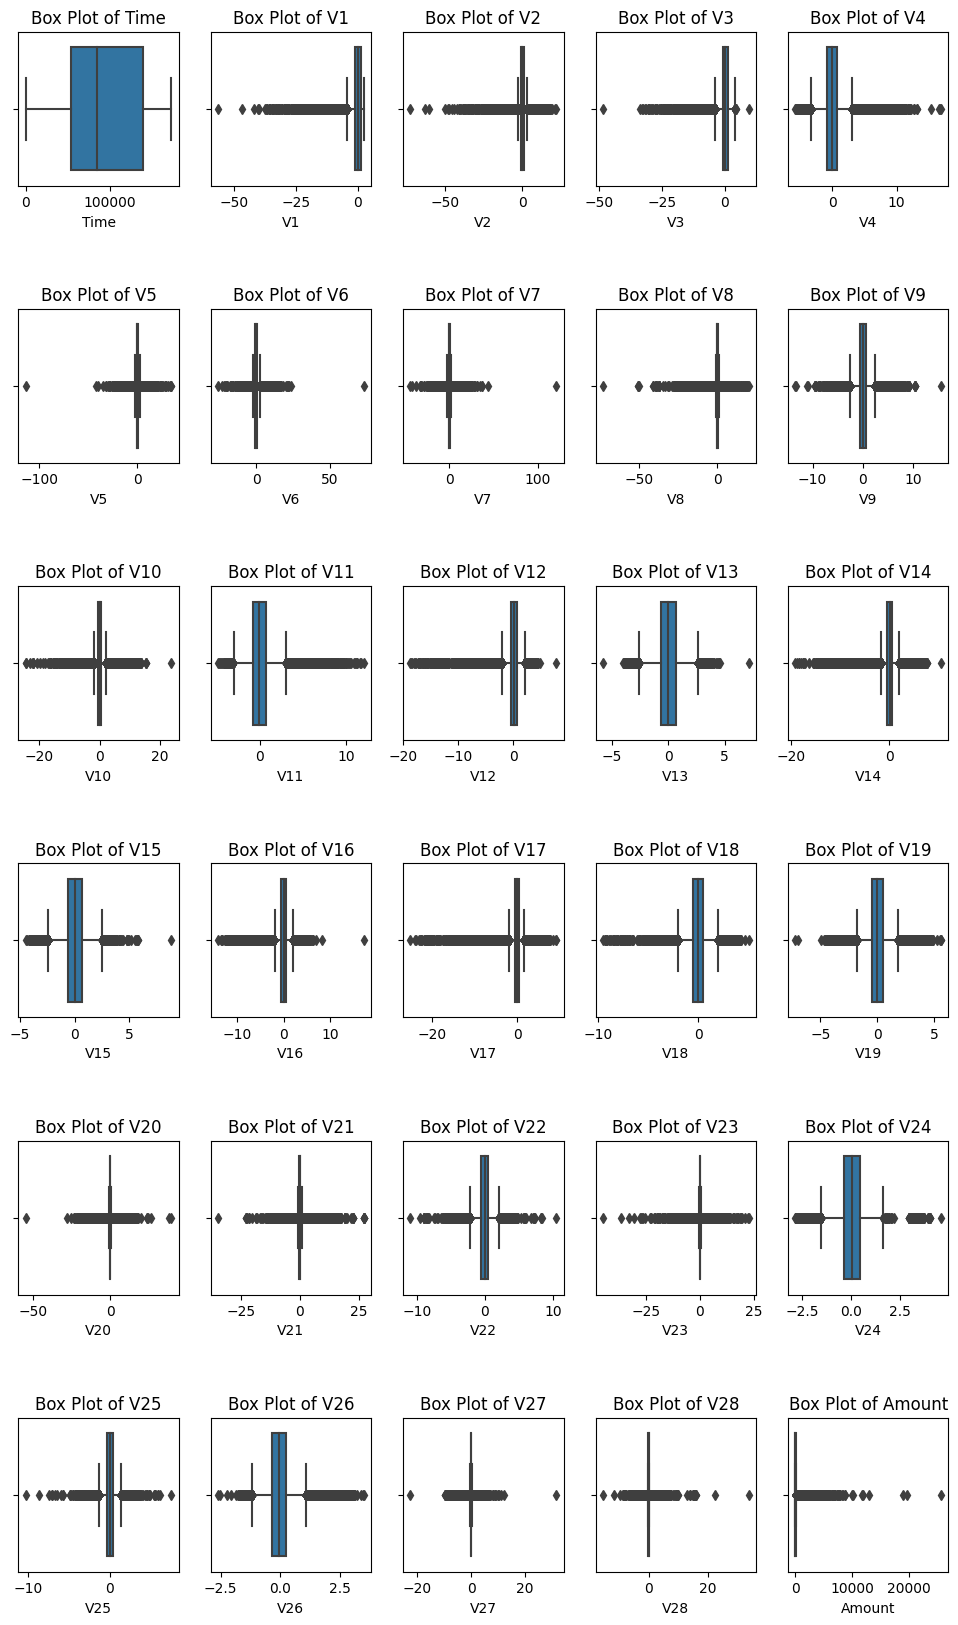

In [7]:
fig, axes=plt.subplots(nrows=6, ncols=5, figsize=(12,20))
axes=axes.flatten()

used_axes = 0

for col in df.columns:
    if col=='Class':
        pass
    
    else:
        sns.boxplot(data=df, x=col, ax=axes[used_axes])
        axes[used_axes].set_title(f'Box Plot of {col}')
        used_axes += 1
        
for ax in axes[used_axes:]:
    fig.delaxes(ax)
    
plt.subplots_adjust(hspace=0.8,wspace=0.2)
plt.show()

In [8]:
def remove_out(data,column):
    '''Removes outliers by taking dataframe and column name as input and returning new dataframe'''
    Q1 = data[column].quantile(.25)
    Q3 = data[column].quantile(.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data=data[(data[column]>=lower_bound) & (data[column]<=upper_bound)]
    return(data)

In [9]:
df_trans = df.copy(deep=True)
for col in df_trans.columns:
    if col=='Class':
        pass
    else:
        df_trans = remove_out(df_trans,col)

In [10]:
# Percentage of Outliers removed
round(df_trans.shape[0]*100/df.shape[0],2)

38.67

In [11]:
df_trans['Class'].value_counts()

Class
0    110109
1        13
Name: count, dtype: int64

#### Note:- We lost a lot of fraud information so outliers can't be removed from this data

#### Robost Scaler

In [12]:
preprocessor = ColumnTransformer(transformers=[('rob_out',RobustScaler(),df.drop(columns=['Class'],axis=1).columns)],
                                 remainder='passthrough')

In [13]:
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('rob_out', RobustScaler(),
                                 Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object'))])

In [14]:
df_trans = preprocessor.fit_transform(df)

In [15]:
# Get Feature names
features = list(df.drop(columns=['Class'],axis=1).columns) + list(['Class'])

# Create the DataFrame
df_trans = pd.DataFrame(df_trans, columns=features)

df_trans.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-0.994983,-0.616237,-0.098602,1.228905,0.878152,-0.217859,0.631245,0.177406,0.142432,0.334787,0.185689,-0.345414,-0.740209,-0.745834,-0.393775,1.152959,-0.541507,0.309758,0.029437,0.437322,0.910463,0.026866,0.253109,-0.320791,0.032681,0.167619,-0.241182,0.816731,-0.246091,1.783274,0.0
1,-0.994983,0.524929,0.143100,-0.006970,0.293974,0.087726,0.164395,-0.105740,0.117064,-0.164482,-0.074854,1.095465,0.903686,0.383407,-0.211569,0.476970,0.400979,-0.055612,-0.179787,-0.163363,-0.019150,-0.473332,-0.602719,0.363442,-0.479557,0.225462,0.313475,-0.063781,0.026519,-0.269825,0.0
2,-0.994972,-0.615587,-1.002407,0.830932,0.251024,-0.344345,1.778007,0.668164,0.420388,-1.179796,0.303796,0.437564,-0.072229,0.557465,-0.235704,1.865539,-2.982344,1.330783,-0.117763,-2.475385,1.703959,0.668917,0.714254,2.974603,-0.919589,-0.515430,-0.153111,-0.350218,-0.540962,4.983721,0.0
3,-0.994972,-0.440239,-0.178789,0.841250,-0.529808,0.033775,1.303832,0.175637,0.662489,-1.076888,0.038374,-0.128974,0.037307,0.397641,-0.368473,-0.551666,-1.135905,-0.700023,1.970088,-1.350843,-0.422194,-0.190105,-0.001408,-0.578786,-1.531963,0.944482,-0.298959,0.379163,0.382611,1.418291,0.0
4,-0.994960,-0.526089,0.579239,0.713861,0.265632,-0.270695,0.317183,0.491625,-0.546463,0.700808,0.855099,-0.525992,0.388903,1.036898,-1.273801,0.103149,-0.522390,-0.193970,-0.034570,0.873809,1.366227,0.048266,0.739092,-0.407980,0.126293,-0.333308,0.976221,1.347133,1.553716,0.670579,0.0


In [16]:
df_trans['Class'].value_counts()

Class
0.0    284315
1.0       492
Name: count, dtype: int64

In [17]:
492/284315

0.0017304750013189597

### Isolation Forest with Class Feature Present Without PCA

In [19]:
isf = IsolationForest(n_estimators=500,contamination=0.02,random_state=14,bootstrap=True)
isf.fit(df_trans)

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(bootstrap=True, contamination=0.02, n_estimators=500,
                random_state=14)

In [20]:
df_trans.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-0.994983,-0.616237,-0.098602,1.228905,0.878152,-0.217859,0.631245,0.177406,0.142432,0.334787,0.185689,-0.345414,-0.740209,-0.745834,-0.393775,1.152959,-0.541507,0.309758,0.029437,0.437322,0.910463,0.026866,0.253109,-0.320791,0.032681,0.167619,-0.241182,0.816731,-0.246091,1.783274,0.0
1,-0.994983,0.524929,0.143100,-0.006970,0.293974,0.087726,0.164395,-0.105740,0.117064,-0.164482,-0.074854,1.095465,0.903686,0.383407,-0.211569,0.476970,0.400979,-0.055612,-0.179787,-0.163363,-0.019150,-0.473332,-0.602719,0.363442,-0.479557,0.225462,0.313475,-0.063781,0.026519,-0.269825,0.0
2,-0.994972,-0.615587,-1.002407,0.830932,0.251024,-0.344345,1.778007,0.668164,0.420388,-1.179796,0.303796,0.437564,-0.072229,0.557465,-0.235704,1.865539,-2.982344,1.330783,-0.117763,-2.475385,1.703959,0.668917,0.714254,2.974603,-0.919589,-0.515430,-0.153111,-0.350218,-0.540962,4.983721,0.0
3,-0.994972,-0.440239,-0.178789,0.841250,-0.529808,0.033775,1.303832,0.175637,0.662489,-1.076888,0.038374,-0.128974,0.037307,0.397641,-0.368473,-0.551666,-1.135905,-0.700023,1.970088,-1.350843,-0.422194,-0.190105,-0.001408,-0.578786,-1.531963,0.944482,-0.298959,0.379163,0.382611,1.418291,0.0
4,-0.994960,-0.526089,0.579239,0.713861,0.265632,-0.270695,0.317183,0.491625,-0.546463,0.700808,0.855099,-0.525992,0.388903,1.036898,-1.273801,0.103149,-0.522390,-0.193970,-0.034570,0.873809,1.366227,0.048266,0.739092,-0.407980,0.126293,-0.333308,0.976221,1.347133,1.553716,0.670579,0.0


In [21]:
isf.get_params()

{'bootstrap': True,
 'contamination': 0.02,
 'max_features': 1.0,
 'max_samples': 'auto',
 'n_estimators': 500,
 'n_jobs': None,
 'random_state': 14,
 'verbose': 0,
 'warm_start': False}

In [23]:
df_pred = df_trans.copy(deep=True)
df_pred['Score'] = isf.decision_function(df_trans)
df_pred['Anomaly_Score'] = isf.predict(df_trans)
df_pred.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,Score,Anomaly_Score
0,-0.994983,-0.616237,-0.098602,1.228905,0.878152,-0.217859,0.631245,0.177406,0.142432,0.334787,0.185689,-0.345414,-0.740209,-0.745834,-0.393775,1.152959,-0.541507,0.309758,0.029437,0.437322,0.910463,0.026866,0.253109,-0.320791,0.032681,0.167619,-0.241182,0.816731,-0.246091,1.783274,0.0,0.147913,1
1,-0.994983,0.524929,0.143100,-0.006970,0.293974,0.087726,0.164395,-0.105740,0.117064,-0.164482,-0.074854,1.095465,0.903686,0.383407,-0.211569,0.476970,0.400979,-0.055612,-0.179787,-0.163363,-0.019150,-0.473332,-0.602719,0.363442,-0.479557,0.225462,0.313475,-0.063781,0.026519,-0.269825,0.0,0.164814,1
2,-0.994972,-0.615587,-1.002407,0.830932,0.251024,-0.344345,1.778007,0.668164,0.420388,-1.179796,0.303796,0.437564,-0.072229,0.557465,-0.235704,1.865539,-2.982344,1.330783,-0.117763,-2.475385,1.703959,0.668917,0.714254,2.974603,-0.919589,-0.515430,-0.153111,-0.350218,-0.540962,4.983721,0.0,0.073962,1
3,-0.994972,-0.440239,-0.178789,0.841250,-0.529808,0.033775,1.303832,0.175637,0.662489,-1.076888,0.038374,-0.128974,0.037307,0.397641,-0.368473,-0.551666,-1.135905,-0.700023,1.970088,-1.350843,-0.422194,-0.190105,-0.001408,-0.578786,-1.531963,0.944482,-0.298959,0.379163,0.382611,1.418291,0.0,0.123929,1
4,-0.994960,-0.526089,0.579239,0.713861,0.265632,-0.270695,0.317183,0.491625,-0.546463,0.700808,0.855099,-0.525992,0.388903,1.036898,-1.273801,0.103149,-0.522390,-0.193970,-0.034570,0.873809,1.366227,0.048266,0.739092,-0.407980,0.126293,-0.333308,0.976221,1.347133,1.553716,0.670579,0.0,0.144050,1


In [24]:
df_pred['Anomaly_Score'].value_counts()

Anomaly_Score
 1    279110
-1      5697
Name: count, dtype: int64

In [25]:
# Creating a dataset of Preduicte anomaly

df_pred[df_pred['Anomaly_Score']==-1]['Class'].value_counts()

Class
0.0    5312
1.0     385
Name: count, dtype: int64

#### Appying PCA and see loss of information and choose correct number of components
***

In [27]:
def pca_selec(data,n_comp):
    '''Takes dataset and no of components it needs to reduced to and returns the caputred variance'''
    pca=PCA(n_components=n_comp)
    res = pca.fit_transform(data)
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance = explained_variance_ratio.cumsum()
    print(f"Total explained variance by {n_comp} components is {cumulative_variance[-1]}")

In [28]:
# Not using Class in PCA

for n in range(2,11):
    pca_selec(df_trans.drop(['Class'],axis=1),n)

Total explained variance by 2 components is 0.33584692936919575
Total explained variance by 3 components is 0.43828632307952486
Total explained variance by 4 components is 0.5202302098765804
Total explained variance by 5 components is 0.593157223836996
Total explained variance by 6 components is 0.6584068421623688
Total explained variance by 7 components is 0.7094474271934682
Total explained variance by 8 components is 0.7312162534497234
Total explained variance by 9 components is 0.7522276796745563
Total explained variance by 10 components is 0.7721942452628074


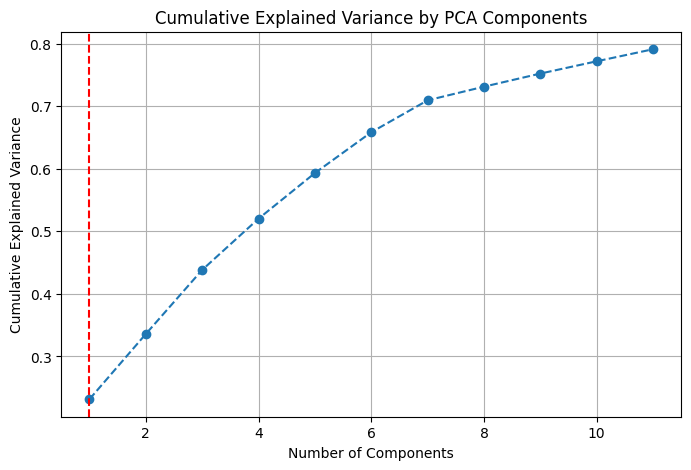

In [29]:
pca = PCA(n_components=11)
X_pca = pca.fit_transform(df_trans.drop(['Class'],axis=1))

# Plot explained variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.axvline(x=np.argmax(cumulative_variance >= 0.95) + 1, color='r', linestyle='--')
plt.grid()
plt.show()


#### We can see the from the data and the elbow plot that after 7 components the addition of variance is very less so we go with n_components=7

In [30]:
pca=PCA(n_components=7)
X_pca = pca.fit_transform(df_trans.drop(['Class'],axis=1))

# Create a DataFrame with PCA components
df_pca = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2', 'PCA3','PCA4', 'PCA5', 'PCA6','PCA7'])

# Add the target variable to the DataFrame
df_pca['target'] = df_trans['Class']

In [31]:
df_pca['target'].value_counts()

target
0.0    284315
1.0       492
Name: count, dtype: int64

In [ ]:
# Initialize the model
isf = IsolationForest(n_estimators=500, bootstrap=True,contamination=0.02, random_state=14)

# Fit the grid search to the data
isf.fit(df_pca.drop(columns=['target'],axis=1))

In [40]:
# Get the acuuracy scores
df_pred = df_pca.copy(deep=True)
df_pred['Score'] = isf.decision_function(df_pca.drop(columns=['target'],axis=1))
df_pred['Anomaly_Score'] = isf.predict(df_pca.drop(columns=['target'],axis=1))
df_pred.head()

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,target,Score,Anomaly_Score
0,1.083934,-0.184792,0.778686,-0.409699,-0.234020,0.430828,0.073053,0.0,0.281054,1
1,-1.288158,0.127843,-0.016751,-0.112734,-0.244124,-0.102810,0.488458,0.0,0.298410,1
2,4.322779,-0.490545,-0.468523,-0.904040,-1.225187,-3.053865,-0.089285,0.0,0.184933,1
3,0.396718,0.469515,0.407148,-0.498130,1.075126,0.197952,0.398312,0.0,0.283188,1
4,0.155850,1.607698,1.332399,0.103743,-1.085040,0.976450,-0.157114,0.0,0.262863,1


In [43]:
df_pred['Anomaly_Score'].value_counts()

Anomaly_Score
 1    279110
-1      5697
Name: count, dtype: int64

In [44]:
# Creating a dataset of Preduicte anomaly

df_pred[df_pred['Anomaly_Score']==-1]['target'].value_counts()

target
0.0    5576
1.0     121
Name: count, dtype: int64

#### DBSCAN Anomalies

#### LOF Method

### Part 02:- Anomaly detection without Class Feature

#### Compare the Results

### Classification Model